## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 100
BATCH_SIZE = 32
CROP_SIZE = 256
Z_START = 8
Z_DIMS = 32
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

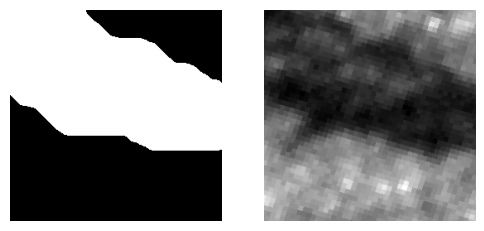

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4108

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                # A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                #                 mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[1, 5]),
                #         A.GaussianBlur(),
                #         A.MotionBlur(),
                #         ], p=0.4),
                # A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                # A.Normalize(
                #     mean= [0] * Z_DIMS,
                #     std= [1] * Z_DIMS
                # ),
                
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-128 if x1 != 0 else 0, 128)
        y_offset = random.randint(-128 if y1 != 0 else 0, 128)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        

        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0., dtype=torch.float64), tensor(1., dtype=torch.float64))

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [13]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [14]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [15]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [16]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [17]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [18]:
import segmentation_models_pytorch as smp
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()


def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/100  Mem : 18.5GB  LR : 4.00E-06  Loss: 0.7959: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                        
Val Loss: 0.7490: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.133444
Threshold : 0.25	FBeta : 0.134291
Threshold : 0.30	FBeta : 0.137992
Threshold : 0.35	FBeta : 0.144264
Threshold : 0.40	FBeta : 0.153928
Threshold : 0.45	FBeta : 0.169562
Threshold : 0.50	FBeta : 0.194707
Threshold : 0.55	FBeta : 0.223965
Threshold : 0.60	FBeta : 0.240182
Threshold : 0.65	FBeta : 0.237107
Threshold : 0.70	FBeta : 0.186050
Threshold : 0.75	FBeta : 0.077909
Threshold : 0.80	FBeta : 0.005740



Epoch 2/100  Mem : 19.8GB  LR : 6.89E-06  Loss: 0.7349: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                        
Val Loss: 0.6769: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.133821
Threshold : 0.25	FBeta : 0.142350
Threshold : 0.30	FBeta : 0.161817
Threshold : 0.35	FBeta : 0.184407
Threshold : 0.40	FBeta : 0.203889
Threshold : 0.45	FBeta : 0.224295
Threshold : 0.50	FBeta : 0.249303
Threshold : 0.55	FBeta : 0.270823
Threshold : 0.60	FBeta : 0.294785
Threshold : 0.65	FBeta : 0.277283
Threshold : 0.70	FBeta : 0.155898
Threshold : 0.75	FBeta : 0.032592
Threshold : 0.80	FBeta : 0.001219



Epoch 3/100  Mem : 19.8GB  LR : 1.52E-05  Loss: 0.6929: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                        
Val Loss: 0.6781: 100%|██████████| 24/24 [00:11<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.140064
Threshold : 0.25	FBeta : 0.164275
Threshold : 0.30	FBeta : 0.182313
Threshold : 0.35	FBeta : 0.194635
Threshold : 0.40	FBeta : 0.202889
Threshold : 0.45	FBeta : 0.211649
Threshold : 0.50	FBeta : 0.221513
Threshold : 0.55	FBeta : 0.222812
Threshold : 0.60	FBeta : 0.219958
Threshold : 0.65	FBeta : 0.183347
Threshold : 0.70	FBeta : 0.117355
Threshold : 0.75	FBeta : 0.048247
Threshold : 0.80	FBeta : 0.013740



Epoch 4/100  Mem : 19.8GB  LR : 2.80E-05  Loss: 0.6509: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                        
Val Loss: 0.6220: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.190586
Threshold : 0.25	FBeta : 0.207280
Threshold : 0.30	FBeta : 0.218556
Threshold : 0.35	FBeta : 0.228345
Threshold : 0.40	FBeta : 0.239816
Threshold : 0.45	FBeta : 0.247544
Threshold : 0.50	FBeta : 0.253414
Threshold : 0.55	FBeta : 0.256987
Threshold : 0.60	FBeta : 0.260539
Threshold : 0.65	FBeta : 0.263268
Threshold : 0.70	FBeta : 0.262673
Threshold : 0.75	FBeta : 0.257073
Threshold : 0.80	FBeta : 0.240560



Epoch 5/100  Mem : 19.8GB  LR : 4.37E-05  Loss: 0.6246: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                        
Val Loss: 0.5943: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.208937
Threshold : 0.25	FBeta : 0.231440
Threshold : 0.30	FBeta : 0.250261
Threshold : 0.35	FBeta : 0.267981
Threshold : 0.40	FBeta : 0.288656
Threshold : 0.45	FBeta : 0.309308
Threshold : 0.50	FBeta : 0.331229
Threshold : 0.55	FBeta : 0.350824
Threshold : 0.60	FBeta : 0.365810
Threshold : 0.65	FBeta : 0.378328
Threshold : 0.70	FBeta : 0.390567
Threshold : 0.75	FBeta : 0.399440
Threshold : 0.80	FBeta : 0.400323



Epoch 6/100  Mem : 19.8GB  LR : 6.03E-05  Loss: 0.6014: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                        
Val Loss: 0.5579: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.206869
Threshold : 0.25	FBeta : 0.244826
Threshold : 0.30	FBeta : 0.295551
Threshold : 0.35	FBeta : 0.330228
Threshold : 0.40	FBeta : 0.348256
Threshold : 0.45	FBeta : 0.363052
Threshold : 0.50	FBeta : 0.376494
Threshold : 0.55	FBeta : 0.386966
Threshold : 0.60	FBeta : 0.394819
Threshold : 0.65	FBeta : 0.383602
Threshold : 0.70	FBeta : 0.357737
Threshold : 0.75	FBeta : 0.313789
Threshold : 0.80	FBeta : 0.257879



Epoch 7/100  Mem : 19.8GB  LR : 7.60E-05  Loss: 0.5871: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                        
Val Loss: 0.6357: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.176293
Threshold : 0.25	FBeta : 0.211095
Threshold : 0.30	FBeta : 0.245451
Threshold : 0.35	FBeta : 0.270700
Threshold : 0.40	FBeta : 0.291870
Threshold : 0.45	FBeta : 0.307374
Threshold : 0.50	FBeta : 0.318758
Threshold : 0.55	FBeta : 0.333204
Threshold : 0.60	FBeta : 0.346301
Threshold : 0.65	FBeta : 0.360116
Threshold : 0.70	FBeta : 0.374022
Threshold : 0.75	FBeta : 0.387153
Threshold : 0.80	FBeta : 0.400988



Epoch 8/100  Mem : 19.8GB  LR : 8.88E-05  Loss: 0.5678: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                        
Val Loss: 0.5576: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.224057
Threshold : 0.25	FBeta : 0.310545
Threshold : 0.30	FBeta : 0.305217
Threshold : 0.35	FBeta : 0.267980
Threshold : 0.40	FBeta : 0.233507
Threshold : 0.45	FBeta : 0.199594
Threshold : 0.50	FBeta : 0.156772
Threshold : 0.55	FBeta : 0.068783
Threshold : 0.60	FBeta : 0.031162
Threshold : 0.65	FBeta : 0.014135
Threshold : 0.70	FBeta : 0.004953
Threshold : 0.75	FBeta : 0.000377
Threshold : 0.80	FBeta : 0.000000



Epoch 9/100  Mem : 19.8GB  LR : 9.71E-05  Loss: 0.5467: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                        
Val Loss: 0.5309: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.365260
Threshold : 0.25	FBeta : 0.454278
Threshold : 0.30	FBeta : 0.454954
Threshold : 0.35	FBeta : 0.445993
Threshold : 0.40	FBeta : 0.436096
Threshold : 0.45	FBeta : 0.424510
Threshold : 0.50	FBeta : 0.403250
Threshold : 0.55	FBeta : 0.325811
Threshold : 0.60	FBeta : 0.272325
Threshold : 0.65	FBeta : 0.219730
Threshold : 0.70	FBeta : 0.161837
Threshold : 0.75	FBeta : 0.102903
Threshold : 0.80	FBeta : 0.051600



Epoch 10/100  Mem : 19.8GB  LR : 1.00E-04  Loss: 0.5334: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.5348: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.281047
Threshold : 0.25	FBeta : 0.302261
Threshold : 0.30	FBeta : 0.314374
Threshold : 0.35	FBeta : 0.323760
Threshold : 0.40	FBeta : 0.331980
Threshold : 0.45	FBeta : 0.339632
Threshold : 0.50	FBeta : 0.348171
Threshold : 0.55	FBeta : 0.353525
Threshold : 0.60	FBeta : 0.348866
Threshold : 0.65	FBeta : 0.339158
Threshold : 0.70	FBeta : 0.324796
Threshold : 0.75	FBeta : 0.306647
Threshold : 0.80	FBeta : 0.281385



Epoch 11/100  Mem : 19.8GB  LR : 1.00E-04  Loss: 0.5091: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.6385: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.251109
Threshold : 0.25	FBeta : 0.263031
Threshold : 0.30	FBeta : 0.271180
Threshold : 0.35	FBeta : 0.276816
Threshold : 0.40	FBeta : 0.281595
Threshold : 0.45	FBeta : 0.286394
Threshold : 0.50	FBeta : 0.294856
Threshold : 0.55	FBeta : 0.318791
Threshold : 0.60	FBeta : 0.328369
Threshold : 0.65	FBeta : 0.339844
Threshold : 0.70	FBeta : 0.352880
Threshold : 0.75	FBeta : 0.367200
Threshold : 0.80	FBeta : 0.382343



Epoch 12/100  Mem : 19.8GB  LR : 9.99E-05  Loss: 0.4912: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.5412: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.304387
Threshold : 0.25	FBeta : 0.298818
Threshold : 0.30	FBeta : 0.294516
Threshold : 0.35	FBeta : 0.294500
Threshold : 0.40	FBeta : 0.294938
Threshold : 0.45	FBeta : 0.295377
Threshold : 0.50	FBeta : 0.291380
Threshold : 0.55	FBeta : 0.268048
Threshold : 0.60	FBeta : 0.258509
Threshold : 0.65	FBeta : 0.246556
Threshold : 0.70	FBeta : 0.214158
Threshold : 0.75	FBeta : 0.168743
Threshold : 0.80	FBeta : 0.123511



Epoch 13/100  Mem : 19.8GB  LR : 9.97E-05  Loss: 0.4872: 100%|██████████| 62/62 [01:14<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4815: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.351380
Threshold : 0.25	FBeta : 0.393856
Threshold : 0.30	FBeta : 0.421939
Threshold : 0.35	FBeta : 0.444674
Threshold : 0.40	FBeta : 0.455626
Threshold : 0.45	FBeta : 0.464125
Threshold : 0.50	FBeta : 0.475723
Threshold : 0.55	FBeta : 0.494532
Threshold : 0.60	FBeta : 0.495735
Threshold : 0.65	FBeta : 0.492832
Threshold : 0.70	FBeta : 0.484659
Threshold : 0.75	FBeta : 0.464371
Threshold : 0.80	FBeta : 0.428654



Epoch 14/100  Mem : 19.8GB  LR : 9.95E-05  Loss: 0.4799: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4805: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.455336
Threshold : 0.25	FBeta : 0.480038
Threshold : 0.30	FBeta : 0.490938
Threshold : 0.35	FBeta : 0.495023
Threshold : 0.40	FBeta : 0.497394
Threshold : 0.45	FBeta : 0.500092
Threshold : 0.50	FBeta : 0.504508
Threshold : 0.55	FBeta : 0.508116
Threshold : 0.60	FBeta : 0.496691
Threshold : 0.65	FBeta : 0.479551
Threshold : 0.70	FBeta : 0.455200
Threshold : 0.75	FBeta : 0.423428
Threshold : 0.80	FBeta : 0.382156



Epoch 15/100  Mem : 19.8GB  LR : 9.92E-05  Loss: 0.4630: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.5691: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.261668
Threshold : 0.25	FBeta : 0.269401
Threshold : 0.30	FBeta : 0.274637
Threshold : 0.35	FBeta : 0.278667
Threshold : 0.40	FBeta : 0.282612
Threshold : 0.45	FBeta : 0.288450
Threshold : 0.50	FBeta : 0.299686
Threshold : 0.55	FBeta : 0.333368
Threshold : 0.60	FBeta : 0.346291
Threshold : 0.65	FBeta : 0.358286
Threshold : 0.70	FBeta : 0.371523
Threshold : 0.75	FBeta : 0.385928
Threshold : 0.80	FBeta : 0.402298



Epoch 16/100  Mem : 19.8GB  LR : 9.89E-05  Loss: 0.4489: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4520: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.416615
Threshold : 0.25	FBeta : 0.438348
Threshold : 0.30	FBeta : 0.451719
Threshold : 0.35	FBeta : 0.460769
Threshold : 0.40	FBeta : 0.468799
Threshold : 0.45	FBeta : 0.476577
Threshold : 0.50	FBeta : 0.485415
Threshold : 0.55	FBeta : 0.495560
Threshold : 0.60	FBeta : 0.502051
Threshold : 0.65	FBeta : 0.505941
Threshold : 0.70	FBeta : 0.506773
Threshold : 0.75	FBeta : 0.500559
Threshold : 0.80	FBeta : 0.483843



Epoch 17/100  Mem : 19.8GB  LR : 9.85E-05  Loss: 0.4480: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4860: 100%|██████████| 24/24 [00:11<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.337779
Threshold : 0.25	FBeta : 0.349586
Threshold : 0.30	FBeta : 0.357640
Threshold : 0.35	FBeta : 0.364868
Threshold : 0.40	FBeta : 0.371840
Threshold : 0.45	FBeta : 0.381611
Threshold : 0.50	FBeta : 0.396984
Threshold : 0.55	FBeta : 0.416690
Threshold : 0.60	FBeta : 0.426747
Threshold : 0.65	FBeta : 0.436628
Threshold : 0.70	FBeta : 0.446583
Threshold : 0.75	FBeta : 0.457017
Threshold : 0.80	FBeta : 0.467265



Epoch 18/100  Mem : 19.8GB  LR : 9.81E-05  Loss: 0.4480: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4493: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.375082
Threshold : 0.25	FBeta : 0.387285
Threshold : 0.30	FBeta : 0.395957
Threshold : 0.35	FBeta : 0.402922
Threshold : 0.40	FBeta : 0.409702
Threshold : 0.45	FBeta : 0.417765
Threshold : 0.50	FBeta : 0.429198
Threshold : 0.55	FBeta : 0.469515
Threshold : 0.60	FBeta : 0.480312
Threshold : 0.65	FBeta : 0.487896
Threshold : 0.70	FBeta : 0.495308
Threshold : 0.75	FBeta : 0.500981
Threshold : 0.80	FBeta : 0.497754



Epoch 19/100  Mem : 19.8GB  LR : 9.76E-05  Loss: 0.4261: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4507: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.366902
Threshold : 0.25	FBeta : 0.382431
Threshold : 0.30	FBeta : 0.393537
Threshold : 0.35	FBeta : 0.402992
Threshold : 0.40	FBeta : 0.412113
Threshold : 0.45	FBeta : 0.423078
Threshold : 0.50	FBeta : 0.435403
Threshold : 0.55	FBeta : 0.448866
Threshold : 0.60	FBeta : 0.462306
Threshold : 0.65	FBeta : 0.477006
Threshold : 0.70	FBeta : 0.491653
Threshold : 0.75	FBeta : 0.507892
Threshold : 0.80	FBeta : 0.520507



Epoch 20/100  Mem : 19.8GB  LR : 9.70E-05  Loss: 0.4321: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.4701: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.367801
Threshold : 0.25	FBeta : 0.379825
Threshold : 0.30	FBeta : 0.387858
Threshold : 0.35	FBeta : 0.394134
Threshold : 0.40	FBeta : 0.400034
Threshold : 0.45	FBeta : 0.405605
Threshold : 0.50	FBeta : 0.411124
Threshold : 0.55	FBeta : 0.416532
Threshold : 0.60	FBeta : 0.422786
Threshold : 0.65	FBeta : 0.429495
Threshold : 0.70	FBeta : 0.436222
Threshold : 0.75	FBeta : 0.443467
Threshold : 0.80	FBeta : 0.449416



Epoch 21/100  Mem : 19.8GB  LR : 9.64E-05  Loss: 0.4219: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.4744: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.408805
Threshold : 0.25	FBeta : 0.416630
Threshold : 0.30	FBeta : 0.421229
Threshold : 0.35	FBeta : 0.422806
Threshold : 0.40	FBeta : 0.422773
Threshold : 0.45	FBeta : 0.422660
Threshold : 0.50	FBeta : 0.421586
Threshold : 0.55	FBeta : 0.418625
Threshold : 0.60	FBeta : 0.415036
Threshold : 0.65	FBeta : 0.410713
Threshold : 0.70	FBeta : 0.399448
Threshold : 0.75	FBeta : 0.383828
Threshold : 0.80	FBeta : 0.359303



Epoch 22/100  Mem : 19.8GB  LR : 9.57E-05  Loss: 0.4169: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4915: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.523737
Threshold : 0.25	FBeta : 0.518504
Threshold : 0.30	FBeta : 0.513948
Threshold : 0.35	FBeta : 0.508650
Threshold : 0.40	FBeta : 0.500699
Threshold : 0.45	FBeta : 0.489294
Threshold : 0.50	FBeta : 0.476322
Threshold : 0.55	FBeta : 0.456600
Threshold : 0.60	FBeta : 0.433131
Threshold : 0.65	FBeta : 0.406677
Threshold : 0.70	FBeta : 0.375716
Threshold : 0.75	FBeta : 0.339098
Threshold : 0.80	FBeta : 0.293555



Epoch 23/100  Mem : 19.8GB  LR : 9.49E-05  Loss: 0.4023: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.7533: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.258831
Threshold : 0.25	FBeta : 0.262205
Threshold : 0.30	FBeta : 0.264862
Threshold : 0.35	FBeta : 0.267045
Threshold : 0.40	FBeta : 0.269292
Threshold : 0.45	FBeta : 0.271976
Threshold : 0.50	FBeta : 0.275799
Threshold : 0.55	FBeta : 0.281786
Threshold : 0.60	FBeta : 0.287956
Threshold : 0.65	FBeta : 0.294252
Threshold : 0.70	FBeta : 0.301422
Threshold : 0.75	FBeta : 0.310540
Threshold : 0.80	FBeta : 0.321963



Epoch 24/100  Mem : 19.8GB  LR : 9.41E-05  Loss: 0.3961: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.5882: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.319437
Threshold : 0.25	FBeta : 0.289474
Threshold : 0.30	FBeta : 0.263572
Threshold : 0.35	FBeta : 0.240453
Threshold : 0.40	FBeta : 0.220115
Threshold : 0.45	FBeta : 0.200869
Threshold : 0.50	FBeta : 0.179575
Threshold : 0.55	FBeta : 0.156007
Threshold : 0.60	FBeta : 0.139206
Threshold : 0.65	FBeta : 0.123342
Threshold : 0.70	FBeta : 0.106881
Threshold : 0.75	FBeta : 0.087802
Threshold : 0.80	FBeta : 0.068028



Epoch 25/100  Mem : 19.8GB  LR : 9.33E-05  Loss: 0.4037: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.5038: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.344753
Threshold : 0.25	FBeta : 0.353365
Threshold : 0.30	FBeta : 0.359533
Threshold : 0.35	FBeta : 0.364956
Threshold : 0.40	FBeta : 0.370332
Threshold : 0.45	FBeta : 0.376039
Threshold : 0.50	FBeta : 0.381633
Threshold : 0.55	FBeta : 0.389190
Threshold : 0.60	FBeta : 0.395842
Threshold : 0.65	FBeta : 0.401259
Threshold : 0.70	FBeta : 0.406348
Threshold : 0.75	FBeta : 0.411906
Threshold : 0.80	FBeta : 0.418808



Epoch 26/100  Mem : 19.8GB  LR : 9.24E-05  Loss: 0.3922: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.4522: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.368776
Threshold : 0.25	FBeta : 0.378465
Threshold : 0.30	FBeta : 0.386528
Threshold : 0.35	FBeta : 0.392259
Threshold : 0.40	FBeta : 0.398794
Threshold : 0.45	FBeta : 0.405906
Threshold : 0.50	FBeta : 0.413011
Threshold : 0.55	FBeta : 0.422342
Threshold : 0.60	FBeta : 0.427423
Threshold : 0.65	FBeta : 0.431197
Threshold : 0.70	FBeta : 0.434067
Threshold : 0.75	FBeta : 0.434092
Threshold : 0.80	FBeta : 0.431640



Epoch 27/100  Mem : 19.8GB  LR : 9.15E-05  Loss: 0.3937: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4299: 100%|██████████| 24/24 [00:11<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.434604
Threshold : 0.25	FBeta : 0.445169
Threshold : 0.30	FBeta : 0.452270
Threshold : 0.35	FBeta : 0.459151
Threshold : 0.40	FBeta : 0.466680
Threshold : 0.45	FBeta : 0.473078
Threshold : 0.50	FBeta : 0.478527
Threshold : 0.55	FBeta : 0.482622
Threshold : 0.60	FBeta : 0.484732
Threshold : 0.65	FBeta : 0.486036
Threshold : 0.70	FBeta : 0.487938
Threshold : 0.75	FBeta : 0.489784
Threshold : 0.80	FBeta : 0.489027



Epoch 28/100  Mem : 19.8GB  LR : 9.05E-05  Loss: 0.3915: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4922: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.511106
Threshold : 0.25	FBeta : 0.503805
Threshold : 0.30	FBeta : 0.495081
Threshold : 0.35	FBeta : 0.485401
Threshold : 0.40	FBeta : 0.475116
Threshold : 0.45	FBeta : 0.465174
Threshold : 0.50	FBeta : 0.454715
Threshold : 0.55	FBeta : 0.442502
Threshold : 0.60	FBeta : 0.426133
Threshold : 0.65	FBeta : 0.402934
Threshold : 0.70	FBeta : 0.374212
Threshold : 0.75	FBeta : 0.339164
Threshold : 0.80	FBeta : 0.294797



Epoch 29/100  Mem : 19.8GB  LR : 8.94E-05  Loss: 0.3678: 100%|██████████| 62/62 [01:14<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4651: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.492466
Threshold : 0.25	FBeta : 0.495774
Threshold : 0.30	FBeta : 0.495864
Threshold : 0.35	FBeta : 0.493274
Threshold : 0.40	FBeta : 0.491060
Threshold : 0.45	FBeta : 0.488091
Threshold : 0.50	FBeta : 0.484498
Threshold : 0.55	FBeta : 0.480936
Threshold : 0.60	FBeta : 0.474173
Threshold : 0.65	FBeta : 0.464135
Threshold : 0.70	FBeta : 0.449510
Threshold : 0.75	FBeta : 0.429433
Threshold : 0.80	FBeta : 0.400537



Epoch 30/100  Mem : 19.8GB  LR : 8.83E-05  Loss: 0.3732: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4313: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.456336
Threshold : 0.25	FBeta : 0.465374
Threshold : 0.30	FBeta : 0.472385
Threshold : 0.35	FBeta : 0.477845
Threshold : 0.40	FBeta : 0.482923
Threshold : 0.45	FBeta : 0.488075
Threshold : 0.50	FBeta : 0.492259
Threshold : 0.55	FBeta : 0.494902
Threshold : 0.60	FBeta : 0.495629
Threshold : 0.65	FBeta : 0.494709
Threshold : 0.70	FBeta : 0.492211
Threshold : 0.75	FBeta : 0.488249
Threshold : 0.80	FBeta : 0.482662



Epoch 31/100  Mem : 19.8GB  LR : 8.72E-05  Loss: 0.3629: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.5304: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.484808
Threshold : 0.25	FBeta : 0.488250
Threshold : 0.30	FBeta : 0.477902
Threshold : 0.35	FBeta : 0.466946
Threshold : 0.40	FBeta : 0.455580
Threshold : 0.45	FBeta : 0.443931
Threshold : 0.50	FBeta : 0.430604
Threshold : 0.55	FBeta : 0.415793
Threshold : 0.60	FBeta : 0.398081
Threshold : 0.65	FBeta : 0.377377
Threshold : 0.70	FBeta : 0.351930
Threshold : 0.75	FBeta : 0.320457
Threshold : 0.80	FBeta : 0.284190



Epoch 32/100  Mem : 19.8GB  LR : 8.60E-05  Loss: 0.3613: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.4561: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.498661
Threshold : 0.25	FBeta : 0.503691
Threshold : 0.30	FBeta : 0.505503
Threshold : 0.35	FBeta : 0.505802
Threshold : 0.40	FBeta : 0.504916
Threshold : 0.45	FBeta : 0.503412
Threshold : 0.50	FBeta : 0.500997
Threshold : 0.55	FBeta : 0.497949
Threshold : 0.60	FBeta : 0.493422
Threshold : 0.65	FBeta : 0.486757
Threshold : 0.70	FBeta : 0.476807
Threshold : 0.75	FBeta : 0.461054
Threshold : 0.80	FBeta : 0.436170



Epoch 33/100  Mem : 19.8GB  LR : 8.47E-05  Loss: 0.3659: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.9002: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.246020
Threshold : 0.25	FBeta : 0.248314
Threshold : 0.30	FBeta : 0.250401
Threshold : 0.35	FBeta : 0.252619
Threshold : 0.40	FBeta : 0.254517
Threshold : 0.45	FBeta : 0.256582
Threshold : 0.50	FBeta : 0.259111
Threshold : 0.55	FBeta : 0.262376
Threshold : 0.60	FBeta : 0.265966
Threshold : 0.65	FBeta : 0.269988
Threshold : 0.70	FBeta : 0.274761
Threshold : 0.75	FBeta : 0.280831
Threshold : 0.80	FBeta : 0.288715



Epoch 34/100  Mem : 19.8GB  LR : 8.35E-05  Loss: 0.3596: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.5930: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.300653
Threshold : 0.25	FBeta : 0.307843
Threshold : 0.30	FBeta : 0.313525
Threshold : 0.35	FBeta : 0.318550
Threshold : 0.40	FBeta : 0.323640
Threshold : 0.45	FBeta : 0.328716
Threshold : 0.50	FBeta : 0.333842
Threshold : 0.55	FBeta : 0.338939
Threshold : 0.60	FBeta : 0.344814
Threshold : 0.65	FBeta : 0.351322
Threshold : 0.70	FBeta : 0.358623
Threshold : 0.75	FBeta : 0.367425
Threshold : 0.80	FBeta : 0.377951



Epoch 35/100  Mem : 19.8GB  LR : 8.21E-05  Loss: 0.3578: 100%|██████████| 62/62 [01:14<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4702: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.530518
Threshold : 0.25	FBeta : 0.530656
Threshold : 0.30	FBeta : 0.530214
Threshold : 0.35	FBeta : 0.528808
Threshold : 0.40	FBeta : 0.526147
Threshold : 0.45	FBeta : 0.520866
Threshold : 0.50	FBeta : 0.514410
Threshold : 0.55	FBeta : 0.505495
Threshold : 0.60	FBeta : 0.493655
Threshold : 0.65	FBeta : 0.476729
Threshold : 0.70	FBeta : 0.453130
Threshold : 0.75	FBeta : 0.421464
Threshold : 0.80	FBeta : 0.380955



Epoch 36/100  Mem : 19.8GB  LR : 8.08E-05  Loss: 0.3463: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.5878: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.312218
Threshold : 0.25	FBeta : 0.319209
Threshold : 0.30	FBeta : 0.325420
Threshold : 0.35	FBeta : 0.331295
Threshold : 0.40	FBeta : 0.337340
Threshold : 0.45	FBeta : 0.343321
Threshold : 0.50	FBeta : 0.349403
Threshold : 0.55	FBeta : 0.354780
Threshold : 0.60	FBeta : 0.360187
Threshold : 0.65	FBeta : 0.366539
Threshold : 0.70	FBeta : 0.374041
Threshold : 0.75	FBeta : 0.382520
Threshold : 0.80	FBeta : 0.392748



Epoch 37/100  Mem : 19.8GB  LR : 7.94E-05  Loss: 0.3628: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4232: 100%|██████████| 24/24 [00:11<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.432075
Threshold : 0.25	FBeta : 0.443746
Threshold : 0.30	FBeta : 0.452547
Threshold : 0.35	FBeta : 0.460409
Threshold : 0.40	FBeta : 0.467978
Threshold : 0.45	FBeta : 0.474971
Threshold : 0.50	FBeta : 0.481626
Threshold : 0.55	FBeta : 0.488266
Threshold : 0.60	FBeta : 0.495690
Threshold : 0.65	FBeta : 0.503289
Threshold : 0.70	FBeta : 0.509930
Threshold : 0.75	FBeta : 0.513881
Threshold : 0.80	FBeta : 0.514278



Epoch 38/100  Mem : 19.8GB  LR : 7.80E-05  Loss: 0.3511: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.4042: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.501963
Threshold : 0.25	FBeta : 0.513564
Threshold : 0.30	FBeta : 0.522510
Threshold : 0.35	FBeta : 0.529055
Threshold : 0.40	FBeta : 0.534721
Threshold : 0.45	FBeta : 0.539409
Threshold : 0.50	FBeta : 0.543167
Threshold : 0.55	FBeta : 0.546550
Threshold : 0.60	FBeta : 0.549369
Threshold : 0.65	FBeta : 0.552179
Threshold : 0.70	FBeta : 0.554398
Threshold : 0.75	FBeta : 0.554460
Threshold : 0.80	FBeta : 0.550944



Epoch 39/100  Mem : 19.8GB  LR : 7.65E-05  Loss: 0.3398: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.5137: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.520431
Threshold : 0.25	FBeta : 0.516107
Threshold : 0.30	FBeta : 0.510310
Threshold : 0.35	FBeta : 0.504194
Threshold : 0.40	FBeta : 0.498678
Threshold : 0.45	FBeta : 0.493507
Threshold : 0.50	FBeta : 0.487862
Threshold : 0.55	FBeta : 0.480947
Threshold : 0.60	FBeta : 0.471978
Threshold : 0.65	FBeta : 0.460217
Threshold : 0.70	FBeta : 0.441701
Threshold : 0.75	FBeta : 0.415556
Threshold : 0.80	FBeta : 0.382509



Epoch 40/100  Mem : 19.8GB  LR : 7.50E-05  Loss: 0.3536: 100%|██████████| 62/62 [01:15<00:00,  1.21s/it]                                                                                                                                                                       
Val Loss: 0.6064: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.350786
Threshold : 0.25	FBeta : 0.329138
Threshold : 0.30	FBeta : 0.309385
Threshold : 0.35	FBeta : 0.293033
Threshold : 0.40	FBeta : 0.279220
Threshold : 0.45	FBeta : 0.265570
Threshold : 0.50	FBeta : 0.252830
Threshold : 0.55	FBeta : 0.239796
Threshold : 0.60	FBeta : 0.227207
Threshold : 0.65	FBeta : 0.211944
Threshold : 0.70	FBeta : 0.195579
Threshold : 0.75	FBeta : 0.176680
Threshold : 0.80	FBeta : 0.154220



Epoch 41/100  Mem : 19.8GB  LR : 7.35E-05  Loss: 0.3400: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.5795: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.416677
Threshold : 0.25	FBeta : 0.402512
Threshold : 0.30	FBeta : 0.389894
Threshold : 0.35	FBeta : 0.378547
Threshold : 0.40	FBeta : 0.368142
Threshold : 0.45	FBeta : 0.358318
Threshold : 0.50	FBeta : 0.348451
Threshold : 0.55	FBeta : 0.338178
Threshold : 0.60	FBeta : 0.324791
Threshold : 0.65	FBeta : 0.306232
Threshold : 0.70	FBeta : 0.283539
Threshold : 0.75	FBeta : 0.256587
Threshold : 0.80	FBeta : 0.226992



Epoch 42/100  Mem : 19.8GB  LR : 7.19E-05  Loss: 0.3379: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4367: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.569279
Threshold : 0.25	FBeta : 0.570592
Threshold : 0.30	FBeta : 0.570613
Threshold : 0.35	FBeta : 0.570472
Threshold : 0.40	FBeta : 0.568924
Threshold : 0.45	FBeta : 0.566777
Threshold : 0.50	FBeta : 0.564120
Threshold : 0.55	FBeta : 0.560646
Threshold : 0.60	FBeta : 0.555126
Threshold : 0.65	FBeta : 0.547194
Threshold : 0.70	FBeta : 0.535374
Threshold : 0.75	FBeta : 0.515150
Threshold : 0.80	FBeta : 0.484202



Epoch 43/100  Mem : 19.8GB  LR : 7.03E-05  Loss: 0.3426: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4223: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.488652
Threshold : 0.25	FBeta : 0.497473
Threshold : 0.30	FBeta : 0.503825
Threshold : 0.35	FBeta : 0.508399
Threshold : 0.40	FBeta : 0.512419
Threshold : 0.45	FBeta : 0.515857
Threshold : 0.50	FBeta : 0.518781
Threshold : 0.55	FBeta : 0.521506
Threshold : 0.60	FBeta : 0.524367
Threshold : 0.65	FBeta : 0.527028
Threshold : 0.70	FBeta : 0.529074
Threshold : 0.75	FBeta : 0.529046
Threshold : 0.80	FBeta : 0.524340



Epoch 44/100  Mem : 19.8GB  LR : 6.87E-05  Loss: 0.3413: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.5332: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.333830
Threshold : 0.25	FBeta : 0.342763
Threshold : 0.30	FBeta : 0.349666
Threshold : 0.35	FBeta : 0.355890
Threshold : 0.40	FBeta : 0.361650
Threshold : 0.45	FBeta : 0.366910
Threshold : 0.50	FBeta : 0.371810
Threshold : 0.55	FBeta : 0.376417
Threshold : 0.60	FBeta : 0.381326
Threshold : 0.65	FBeta : 0.386662
Threshold : 0.70	FBeta : 0.392515
Threshold : 0.75	FBeta : 0.399976
Threshold : 0.80	FBeta : 0.409298



Epoch 45/100  Mem : 19.8GB  LR : 6.71E-05  Loss: 0.3306: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4401: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.402235
Threshold : 0.25	FBeta : 0.410821
Threshold : 0.30	FBeta : 0.417595
Threshold : 0.35	FBeta : 0.423714
Threshold : 0.40	FBeta : 0.428721
Threshold : 0.45	FBeta : 0.432891
Threshold : 0.50	FBeta : 0.436718
Threshold : 0.55	FBeta : 0.440468
Threshold : 0.60	FBeta : 0.444155
Threshold : 0.65	FBeta : 0.448509
Threshold : 0.70	FBeta : 0.452810
Threshold : 0.75	FBeta : 0.456060
Threshold : 0.80	FBeta : 0.460999



Epoch 46/100  Mem : 19.8GB  LR : 6.55E-05  Loss: 0.3291: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4081: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.448383
Threshold : 0.25	FBeta : 0.462746
Threshold : 0.30	FBeta : 0.473730
Threshold : 0.35	FBeta : 0.482661
Threshold : 0.40	FBeta : 0.490634
Threshold : 0.45	FBeta : 0.497099
Threshold : 0.50	FBeta : 0.502666
Threshold : 0.55	FBeta : 0.508159
Threshold : 0.60	FBeta : 0.513746
Threshold : 0.65	FBeta : 0.519403
Threshold : 0.70	FBeta : 0.525476
Threshold : 0.75	FBeta : 0.529288
Threshold : 0.80	FBeta : 0.530397



Epoch 47/100  Mem : 19.8GB  LR : 6.38E-05  Loss: 0.3275: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4931: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.358406
Threshold : 0.25	FBeta : 0.367522
Threshold : 0.30	FBeta : 0.374859
Threshold : 0.35	FBeta : 0.380961
Threshold : 0.40	FBeta : 0.386320
Threshold : 0.45	FBeta : 0.391112
Threshold : 0.50	FBeta : 0.395768
Threshold : 0.55	FBeta : 0.400614
Threshold : 0.60	FBeta : 0.406086
Threshold : 0.65	FBeta : 0.412541
Threshold : 0.70	FBeta : 0.420994
Threshold : 0.75	FBeta : 0.431660
Threshold : 0.80	FBeta : 0.445200



Epoch 48/100  Mem : 19.8GB  LR : 6.21E-05  Loss: 0.3318: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4623: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.380878
Threshold : 0.25	FBeta : 0.389067
Threshold : 0.30	FBeta : 0.395822
Threshold : 0.35	FBeta : 0.401776
Threshold : 0.40	FBeta : 0.407097
Threshold : 0.45	FBeta : 0.412179
Threshold : 0.50	FBeta : 0.417140
Threshold : 0.55	FBeta : 0.421736
Threshold : 0.60	FBeta : 0.425946
Threshold : 0.65	FBeta : 0.430468
Threshold : 0.70	FBeta : 0.435137
Threshold : 0.75	FBeta : 0.440024
Threshold : 0.80	FBeta : 0.446332



Epoch 49/100  Mem : 19.8GB  LR : 6.04E-05  Loss: 0.3323: 100%|██████████| 62/62 [01:12<00:00,  1.17s/it]                                                                                                                                                                       
Val Loss: 0.4719: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.539581
Threshold : 0.25	FBeta : 0.537330
Threshold : 0.30	FBeta : 0.535597
Threshold : 0.35	FBeta : 0.533207
Threshold : 0.40	FBeta : 0.529830
Threshold : 0.45	FBeta : 0.525972
Threshold : 0.50	FBeta : 0.521792
Threshold : 0.55	FBeta : 0.516779
Threshold : 0.60	FBeta : 0.511326
Threshold : 0.65	FBeta : 0.503329
Threshold : 0.70	FBeta : 0.494451
Threshold : 0.75	FBeta : 0.483498
Threshold : 0.80	FBeta : 0.465908



Epoch 50/100  Mem : 19.8GB  LR : 5.87E-05  Loss: 0.3153: 100%|██████████| 62/62 [01:14<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.5158: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.521466
Threshold : 0.25	FBeta : 0.512185
Threshold : 0.30	FBeta : 0.504505
Threshold : 0.35	FBeta : 0.497445
Threshold : 0.40	FBeta : 0.489612
Threshold : 0.45	FBeta : 0.481615
Threshold : 0.50	FBeta : 0.472448
Threshold : 0.55	FBeta : 0.462616
Threshold : 0.60	FBeta : 0.451914
Threshold : 0.65	FBeta : 0.438442
Threshold : 0.70	FBeta : 0.420106
Threshold : 0.75	FBeta : 0.398893
Threshold : 0.80	FBeta : 0.374795



Epoch 51/100  Mem : 19.8GB  LR : 5.70E-05  Loss: 0.3112: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4963: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.552105
Threshold : 0.25	FBeta : 0.547759
Threshold : 0.30	FBeta : 0.541764
Threshold : 0.35	FBeta : 0.536589
Threshold : 0.40	FBeta : 0.529489
Threshold : 0.45	FBeta : 0.520328
Threshold : 0.50	FBeta : 0.511347
Threshold : 0.55	FBeta : 0.501480
Threshold : 0.60	FBeta : 0.489861
Threshold : 0.65	FBeta : 0.474414
Threshold : 0.70	FBeta : 0.454583
Threshold : 0.75	FBeta : 0.429634
Threshold : 0.80	FBeta : 0.399047



Epoch 52/100  Mem : 19.8GB  LR : 5.52E-05  Loss: 0.3173: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4082: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.420601
Threshold : 0.25	FBeta : 0.432176
Threshold : 0.30	FBeta : 0.442041
Threshold : 0.35	FBeta : 0.451108
Threshold : 0.40	FBeta : 0.459326
Threshold : 0.45	FBeta : 0.467135
Threshold : 0.50	FBeta : 0.474942
Threshold : 0.55	FBeta : 0.482646
Threshold : 0.60	FBeta : 0.491818
Threshold : 0.65	FBeta : 0.501840
Threshold : 0.70	FBeta : 0.511780
Threshold : 0.75	FBeta : 0.522434
Threshold : 0.80	FBeta : 0.532782



Epoch 53/100  Mem : 19.8GB  LR : 5.35E-05  Loss: 0.3046: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4624: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.534651
Threshold : 0.25	FBeta : 0.537166
Threshold : 0.30	FBeta : 0.538965
Threshold : 0.35	FBeta : 0.540238
Threshold : 0.40	FBeta : 0.541179
Threshold : 0.45	FBeta : 0.541925
Threshold : 0.50	FBeta : 0.541987
Threshold : 0.55	FBeta : 0.540683
Threshold : 0.60	FBeta : 0.538489
Threshold : 0.65	FBeta : 0.535219
Threshold : 0.70	FBeta : 0.531490
Threshold : 0.75	FBeta : 0.525160
Threshold : 0.80	FBeta : 0.514533



Epoch 54/100  Mem : 19.8GB  LR : 5.17E-05  Loss: 0.3125: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4666: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.566463
Threshold : 0.25	FBeta : 0.564328
Threshold : 0.30	FBeta : 0.561441
Threshold : 0.35	FBeta : 0.556343
Threshold : 0.40	FBeta : 0.550390
Threshold : 0.45	FBeta : 0.544909
Threshold : 0.50	FBeta : 0.539545
Threshold : 0.55	FBeta : 0.533456
Threshold : 0.60	FBeta : 0.525592
Threshold : 0.65	FBeta : 0.515258
Threshold : 0.70	FBeta : 0.502734
Threshold : 0.75	FBeta : 0.485101
Threshold : 0.80	FBeta : 0.459600



Epoch 55/100  Mem : 19.8GB  LR : 5.00E-05  Loss: 0.3072: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4203: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.516053
Threshold : 0.25	FBeta : 0.530152
Threshold : 0.30	FBeta : 0.537847
Threshold : 0.35	FBeta : 0.543440
Threshold : 0.40	FBeta : 0.547382
Threshold : 0.45	FBeta : 0.550352
Threshold : 0.50	FBeta : 0.552440
Threshold : 0.55	FBeta : 0.552747
Threshold : 0.60	FBeta : 0.552480
Threshold : 0.65	FBeta : 0.551203
Threshold : 0.70	FBeta : 0.548697
Threshold : 0.75	FBeta : 0.542794
Threshold : 0.80	FBeta : 0.535172



Epoch 56/100  Mem : 19.8GB  LR : 4.83E-05  Loss: 0.3151: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4296: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.512030
Threshold : 0.25	FBeta : 0.517505
Threshold : 0.30	FBeta : 0.522732
Threshold : 0.35	FBeta : 0.527180
Threshold : 0.40	FBeta : 0.529682
Threshold : 0.45	FBeta : 0.531838
Threshold : 0.50	FBeta : 0.533535
Threshold : 0.55	FBeta : 0.535425
Threshold : 0.60	FBeta : 0.537552
Threshold : 0.65	FBeta : 0.539048
Threshold : 0.70	FBeta : 0.539668
Threshold : 0.75	FBeta : 0.537053
Threshold : 0.80	FBeta : 0.531098



Epoch 57/100  Mem : 19.8GB  LR : 4.65E-05  Loss: 0.3093: 100%|██████████| 62/62 [01:12<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.4206: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.522400
Threshold : 0.25	FBeta : 0.530448
Threshold : 0.30	FBeta : 0.536539
Threshold : 0.35	FBeta : 0.540762
Threshold : 0.40	FBeta : 0.542642
Threshold : 0.45	FBeta : 0.544170
Threshold : 0.50	FBeta : 0.545621
Threshold : 0.55	FBeta : 0.546360
Threshold : 0.60	FBeta : 0.546709
Threshold : 0.65	FBeta : 0.544397
Threshold : 0.70	FBeta : 0.540988
Threshold : 0.75	FBeta : 0.536875
Threshold : 0.80	FBeta : 0.529302



Epoch 58/100  Mem : 19.8GB  LR : 4.48E-05  Loss: 0.3063: 100%|██████████| 62/62 [01:14<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4051: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.435053
Threshold : 0.25	FBeta : 0.447621
Threshold : 0.30	FBeta : 0.458487
Threshold : 0.35	FBeta : 0.467974
Threshold : 0.40	FBeta : 0.477285
Threshold : 0.45	FBeta : 0.486196
Threshold : 0.50	FBeta : 0.495518
Threshold : 0.55	FBeta : 0.504921
Threshold : 0.60	FBeta : 0.513929
Threshold : 0.65	FBeta : 0.523206
Threshold : 0.70	FBeta : 0.529672
Threshold : 0.75	FBeta : 0.536586
Threshold : 0.80	FBeta : 0.542361



Epoch 59/100  Mem : 19.8GB  LR : 4.30E-05  Loss: 0.2953: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4717: 100%|██████████| 24/24 [00:11<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.522399
Threshold : 0.25	FBeta : 0.522010
Threshold : 0.30	FBeta : 0.521736
Threshold : 0.35	FBeta : 0.521220
Threshold : 0.40	FBeta : 0.519915
Threshold : 0.45	FBeta : 0.518045
Threshold : 0.50	FBeta : 0.515620
Threshold : 0.55	FBeta : 0.511798
Threshold : 0.60	FBeta : 0.506495
Threshold : 0.65	FBeta : 0.499373
Threshold : 0.70	FBeta : 0.489467
Threshold : 0.75	FBeta : 0.478412
Threshold : 0.80	FBeta : 0.464711



Epoch 60/100  Mem : 19.8GB  LR : 4.13E-05  Loss: 0.3059: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4132: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.488681
Threshold : 0.25	FBeta : 0.499095
Threshold : 0.30	FBeta : 0.506700
Threshold : 0.35	FBeta : 0.513317
Threshold : 0.40	FBeta : 0.519150
Threshold : 0.45	FBeta : 0.523444
Threshold : 0.50	FBeta : 0.526943
Threshold : 0.55	FBeta : 0.530194
Threshold : 0.60	FBeta : 0.533442
Threshold : 0.65	FBeta : 0.536535
Threshold : 0.70	FBeta : 0.538558
Threshold : 0.75	FBeta : 0.539207
Threshold : 0.80	FBeta : 0.537119



Epoch 61/100  Mem : 19.8GB  LR : 3.96E-05  Loss: 0.2976: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4520: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.566144
Threshold : 0.25	FBeta : 0.567825
Threshold : 0.30	FBeta : 0.568584
Threshold : 0.35	FBeta : 0.568009
Threshold : 0.40	FBeta : 0.566146
Threshold : 0.45	FBeta : 0.563738
Threshold : 0.50	FBeta : 0.561453
Threshold : 0.55	FBeta : 0.558304
Threshold : 0.60	FBeta : 0.554704
Threshold : 0.65	FBeta : 0.549398
Threshold : 0.70	FBeta : 0.541989
Threshold : 0.75	FBeta : 0.532674
Threshold : 0.80	FBeta : 0.520015



Epoch 62/100  Mem : 19.8GB  LR : 3.79E-05  Loss: 0.3004: 100%|██████████| 62/62 [01:15<00:00,  1.21s/it]                                                                                                                                                                       
Val Loss: 0.5129: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.467452
Threshold : 0.25	FBeta : 0.506699
Threshold : 0.30	FBeta : 0.505932
Threshold : 0.35	FBeta : 0.502584
Threshold : 0.40	FBeta : 0.497810
Threshold : 0.45	FBeta : 0.492738
Threshold : 0.50	FBeta : 0.486643
Threshold : 0.55	FBeta : 0.480891
Threshold : 0.60	FBeta : 0.473326
Threshold : 0.65	FBeta : 0.465043
Threshold : 0.70	FBeta : 0.454264
Threshold : 0.75	FBeta : 0.439274
Threshold : 0.80	FBeta : 0.419711



Epoch 63/100  Mem : 19.8GB  LR : 3.62E-05  Loss: 0.2980: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4773: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.553302
Threshold : 0.25	FBeta : 0.552434
Threshold : 0.30	FBeta : 0.549321
Threshold : 0.35	FBeta : 0.544514
Threshold : 0.40	FBeta : 0.538907
Threshold : 0.45	FBeta : 0.532077
Threshold : 0.50	FBeta : 0.524096
Threshold : 0.55	FBeta : 0.516367
Threshold : 0.60	FBeta : 0.507480
Threshold : 0.65	FBeta : 0.495753
Threshold : 0.70	FBeta : 0.480892
Threshold : 0.75	FBeta : 0.459076
Threshold : 0.80	FBeta : 0.427891



Epoch 64/100  Mem : 19.8GB  LR : 3.45E-05  Loss: 0.3009: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4716: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.561048
Threshold : 0.25	FBeta : 0.562402
Threshold : 0.30	FBeta : 0.561153
Threshold : 0.35	FBeta : 0.557478
Threshold : 0.40	FBeta : 0.552859
Threshold : 0.45	FBeta : 0.548123
Threshold : 0.50	FBeta : 0.543420
Threshold : 0.55	FBeta : 0.538097
Threshold : 0.60	FBeta : 0.531703
Threshold : 0.65	FBeta : 0.524590
Threshold : 0.70	FBeta : 0.516233
Threshold : 0.75	FBeta : 0.504041
Threshold : 0.80	FBeta : 0.484036



Epoch 65/100  Mem : 19.8GB  LR : 3.29E-05  Loss: 0.2818: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.4507: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.546191
Threshold : 0.25	FBeta : 0.548822
Threshold : 0.30	FBeta : 0.549880
Threshold : 0.35	FBeta : 0.549739
Threshold : 0.40	FBeta : 0.548733
Threshold : 0.45	FBeta : 0.546886
Threshold : 0.50	FBeta : 0.544810
Threshold : 0.55	FBeta : 0.542379
Threshold : 0.60	FBeta : 0.538884
Threshold : 0.65	FBeta : 0.534887
Threshold : 0.70	FBeta : 0.528479
Threshold : 0.75	FBeta : 0.518847
Threshold : 0.80	FBeta : 0.505594



Epoch 66/100  Mem : 19.8GB  LR : 3.13E-05  Loss: 0.2869: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4376: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.543914
Threshold : 0.25	FBeta : 0.551353
Threshold : 0.30	FBeta : 0.556560
Threshold : 0.35	FBeta : 0.559251
Threshold : 0.40	FBeta : 0.561181
Threshold : 0.45	FBeta : 0.562757
Threshold : 0.50	FBeta : 0.562835
Threshold : 0.55	FBeta : 0.560777
Threshold : 0.60	FBeta : 0.558133
Threshold : 0.65	FBeta : 0.552930
Threshold : 0.70	FBeta : 0.545086
Threshold : 0.75	FBeta : 0.534103
Threshold : 0.80	FBeta : 0.518869



Epoch 67/100  Mem : 19.8GB  LR : 2.97E-05  Loss: 0.2819: 100%|██████████| 62/62 [01:12<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.4096: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.538019
Threshold : 0.25	FBeta : 0.546588
Threshold : 0.30	FBeta : 0.552367
Threshold : 0.35	FBeta : 0.556183
Threshold : 0.40	FBeta : 0.559872
Threshold : 0.45	FBeta : 0.563844
Threshold : 0.50	FBeta : 0.566534
Threshold : 0.55	FBeta : 0.567972
Threshold : 0.60	FBeta : 0.569043
Threshold : 0.65	FBeta : 0.569234
Threshold : 0.70	FBeta : 0.568820
Threshold : 0.75	FBeta : 0.566160
Threshold : 0.80	FBeta : 0.557851



Epoch 68/100  Mem : 19.8GB  LR : 2.81E-05  Loss: 0.2820: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.4228: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.570229
Threshold : 0.25	FBeta : 0.575491
Threshold : 0.30	FBeta : 0.578834
Threshold : 0.35	FBeta : 0.581031
Threshold : 0.40	FBeta : 0.582020
Threshold : 0.45	FBeta : 0.581774
Threshold : 0.50	FBeta : 0.581012
Threshold : 0.55	FBeta : 0.580166
Threshold : 0.60	FBeta : 0.578126
Threshold : 0.65	FBeta : 0.574845
Threshold : 0.70	FBeta : 0.568774
Threshold : 0.75	FBeta : 0.560285
Threshold : 0.80	FBeta : 0.547923



Epoch 69/100  Mem : 19.8GB  LR : 2.65E-05  Loss: 0.2836: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4355: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.556548
Threshold : 0.25	FBeta : 0.561285
Threshold : 0.30	FBeta : 0.563708
Threshold : 0.35	FBeta : 0.565363
Threshold : 0.40	FBeta : 0.566668
Threshold : 0.45	FBeta : 0.567528
Threshold : 0.50	FBeta : 0.568385
Threshold : 0.55	FBeta : 0.569098
Threshold : 0.60	FBeta : 0.569270
Threshold : 0.65	FBeta : 0.568795
Threshold : 0.70	FBeta : 0.566389
Threshold : 0.75	FBeta : 0.562037
Threshold : 0.80	FBeta : 0.554572



Epoch 70/100  Mem : 19.8GB  LR : 2.50E-05  Loss: 0.2819: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4046: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.476943
Threshold : 0.25	FBeta : 0.488957
Threshold : 0.30	FBeta : 0.498546
Threshold : 0.35	FBeta : 0.506672
Threshold : 0.40	FBeta : 0.513201
Threshold : 0.45	FBeta : 0.519353
Threshold : 0.50	FBeta : 0.525121
Threshold : 0.55	FBeta : 0.531037
Threshold : 0.60	FBeta : 0.536985
Threshold : 0.65	FBeta : 0.542997
Threshold : 0.70	FBeta : 0.549443
Threshold : 0.75	FBeta : 0.556248
Threshold : 0.80	FBeta : 0.563246



Epoch 71/100  Mem : 19.8GB  LR : 2.35E-05  Loss: 0.2715: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.3940: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.509463
Threshold : 0.25	FBeta : 0.521215
Threshold : 0.30	FBeta : 0.529406
Threshold : 0.35	FBeta : 0.535935
Threshold : 0.40	FBeta : 0.541711
Threshold : 0.45	FBeta : 0.546955
Threshold : 0.50	FBeta : 0.551570
Threshold : 0.55	FBeta : 0.555538
Threshold : 0.60	FBeta : 0.558988
Threshold : 0.65	FBeta : 0.561749
Threshold : 0.70	FBeta : 0.564788
Threshold : 0.75	FBeta : 0.567354
Threshold : 0.80	FBeta : 0.567704



Epoch 72/100  Mem : 19.8GB  LR : 2.20E-05  Loss: 0.2677: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.3957: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.533144
Threshold : 0.25	FBeta : 0.542789
Threshold : 0.30	FBeta : 0.549694
Threshold : 0.35	FBeta : 0.555856
Threshold : 0.40	FBeta : 0.561081
Threshold : 0.45	FBeta : 0.564445
Threshold : 0.50	FBeta : 0.566733
Threshold : 0.55	FBeta : 0.568534
Threshold : 0.60	FBeta : 0.570445
Threshold : 0.65	FBeta : 0.572710
Threshold : 0.70	FBeta : 0.575184
Threshold : 0.75	FBeta : 0.575420
Threshold : 0.80	FBeta : 0.573631



Epoch 73/100  Mem : 19.8GB  LR : 2.06E-05  Loss: 0.2696: 100%|██████████| 62/62 [01:14<00:00,  1.21s/it]                                                                                                                                                                       
Val Loss: 0.3903: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.528885
Threshold : 0.25	FBeta : 0.538164
Threshold : 0.30	FBeta : 0.545350
Threshold : 0.35	FBeta : 0.551141
Threshold : 0.40	FBeta : 0.556336
Threshold : 0.45	FBeta : 0.561329
Threshold : 0.50	FBeta : 0.565640
Threshold : 0.55	FBeta : 0.569015
Threshold : 0.60	FBeta : 0.572286
Threshold : 0.65	FBeta : 0.575021
Threshold : 0.70	FBeta : 0.577305
Threshold : 0.75	FBeta : 0.578217
Threshold : 0.80	FBeta : 0.578755



Epoch 74/100  Mem : 19.8GB  LR : 1.92E-05  Loss: 0.2750: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.4260: 100%|██████████| 24/24 [00:11<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.521312
Threshold : 0.25	FBeta : 0.527426
Threshold : 0.30	FBeta : 0.532015
Threshold : 0.35	FBeta : 0.536359
Threshold : 0.40	FBeta : 0.539627
Threshold : 0.45	FBeta : 0.541879
Threshold : 0.50	FBeta : 0.543457
Threshold : 0.55	FBeta : 0.545202
Threshold : 0.60	FBeta : 0.547137
Threshold : 0.65	FBeta : 0.548388
Threshold : 0.70	FBeta : 0.546505
Threshold : 0.75	FBeta : 0.540783
Threshold : 0.80	FBeta : 0.530644



Epoch 75/100  Mem : 19.8GB  LR : 1.79E-05  Loss: 0.2701: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4005: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.534590
Threshold : 0.25	FBeta : 0.543632
Threshold : 0.30	FBeta : 0.550983
Threshold : 0.35	FBeta : 0.556926
Threshold : 0.40	FBeta : 0.561655
Threshold : 0.45	FBeta : 0.565562
Threshold : 0.50	FBeta : 0.568838
Threshold : 0.55	FBeta : 0.572025
Threshold : 0.60	FBeta : 0.575015
Threshold : 0.65	FBeta : 0.577904
Threshold : 0.70	FBeta : 0.581231
Threshold : 0.75	FBeta : 0.582099
Threshold : 0.80	FBeta : 0.579067



Epoch 76/100  Mem : 19.8GB  LR : 1.65E-05  Loss: 0.2690: 100%|██████████| 62/62 [01:14<00:00,  1.21s/it]                                                                                                                                                                       
Val Loss: 0.4025: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.499291
Threshold : 0.25	FBeta : 0.508109
Threshold : 0.30	FBeta : 0.514891
Threshold : 0.35	FBeta : 0.520588
Threshold : 0.40	FBeta : 0.525977
Threshold : 0.45	FBeta : 0.531007
Threshold : 0.50	FBeta : 0.535676
Threshold : 0.55	FBeta : 0.539575
Threshold : 0.60	FBeta : 0.544157
Threshold : 0.65	FBeta : 0.549016
Threshold : 0.70	FBeta : 0.553430
Threshold : 0.75	FBeta : 0.557697
Threshold : 0.80	FBeta : 0.560480



Epoch 77/100  Mem : 19.8GB  LR : 1.53E-05  Loss: 0.2587: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4435: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.576764
Threshold : 0.25	FBeta : 0.578501
Threshold : 0.30	FBeta : 0.578744
Threshold : 0.35	FBeta : 0.578078
Threshold : 0.40	FBeta : 0.576931
Threshold : 0.45	FBeta : 0.574887
Threshold : 0.50	FBeta : 0.571819
Threshold : 0.55	FBeta : 0.568621
Threshold : 0.60	FBeta : 0.563817
Threshold : 0.65	FBeta : 0.557620
Threshold : 0.70	FBeta : 0.550764
Threshold : 0.75	FBeta : 0.540793
Threshold : 0.80	FBeta : 0.529214



Epoch 78/100  Mem : 19.8GB  LR : 1.40E-05  Loss: 0.2660: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4254: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.547943
Threshold : 0.25	FBeta : 0.553351
Threshold : 0.30	FBeta : 0.556989
Threshold : 0.35	FBeta : 0.559225
Threshold : 0.40	FBeta : 0.560486
Threshold : 0.45	FBeta : 0.561002
Threshold : 0.50	FBeta : 0.560819
Threshold : 0.55	FBeta : 0.560206
Threshold : 0.60	FBeta : 0.559252
Threshold : 0.65	FBeta : 0.558161
Threshold : 0.70	FBeta : 0.556586
Threshold : 0.75	FBeta : 0.553854
Threshold : 0.80	FBeta : 0.547551



Epoch 79/100  Mem : 19.8GB  LR : 1.28E-05  Loss: 0.2662: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4300: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.542256
Threshold : 0.25	FBeta : 0.551302
Threshold : 0.30	FBeta : 0.557282
Threshold : 0.35	FBeta : 0.561328
Threshold : 0.40	FBeta : 0.564048
Threshold : 0.45	FBeta : 0.565763
Threshold : 0.50	FBeta : 0.566350
Threshold : 0.55	FBeta : 0.566294
Threshold : 0.60	FBeta : 0.565472
Threshold : 0.65	FBeta : 0.563653
Threshold : 0.70	FBeta : 0.561140
Threshold : 0.75	FBeta : 0.553533
Threshold : 0.80	FBeta : 0.541448



Epoch 80/100  Mem : 19.8GB  LR : 1.17E-05  Loss: 0.2636: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4131: 100%|██████████| 24/24 [00:11<00:00,  2.00it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.529605
Threshold : 0.25	FBeta : 0.537622
Threshold : 0.30	FBeta : 0.543325
Threshold : 0.35	FBeta : 0.546787
Threshold : 0.40	FBeta : 0.549257
Threshold : 0.45	FBeta : 0.551330
Threshold : 0.50	FBeta : 0.553063
Threshold : 0.55	FBeta : 0.554107
Threshold : 0.60	FBeta : 0.555265
Threshold : 0.65	FBeta : 0.556398
Threshold : 0.70	FBeta : 0.557392
Threshold : 0.75	FBeta : 0.557295
Threshold : 0.80	FBeta : 0.553205



Epoch 81/100  Mem : 19.8GB  LR : 1.06E-05  Loss: 0.2619: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4091: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.501394
Threshold : 0.25	FBeta : 0.511776
Threshold : 0.30	FBeta : 0.519733
Threshold : 0.35	FBeta : 0.526326
Threshold : 0.40	FBeta : 0.531757
Threshold : 0.45	FBeta : 0.535768
Threshold : 0.50	FBeta : 0.538814
Threshold : 0.55	FBeta : 0.541450
Threshold : 0.60	FBeta : 0.543900
Threshold : 0.65	FBeta : 0.546373
Threshold : 0.70	FBeta : 0.548051
Threshold : 0.75	FBeta : 0.549743
Threshold : 0.80	FBeta : 0.549080



Epoch 82/100  Mem : 19.8GB  LR : 9.55E-06  Loss: 0.2500: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4049: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.515386
Threshold : 0.25	FBeta : 0.524720
Threshold : 0.30	FBeta : 0.532165
Threshold : 0.35	FBeta : 0.538675
Threshold : 0.40	FBeta : 0.544296
Threshold : 0.45	FBeta : 0.548175
Threshold : 0.50	FBeta : 0.551276
Threshold : 0.55	FBeta : 0.554001
Threshold : 0.60	FBeta : 0.556185
Threshold : 0.65	FBeta : 0.557946
Threshold : 0.70	FBeta : 0.558977
Threshold : 0.75	FBeta : 0.558740
Threshold : 0.80	FBeta : 0.557502



Epoch 83/100  Mem : 19.8GB  LR : 8.55E-06  Loss: 0.2589: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4127: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.515955
Threshold : 0.25	FBeta : 0.524589
Threshold : 0.30	FBeta : 0.531234
Threshold : 0.35	FBeta : 0.537683
Threshold : 0.40	FBeta : 0.543286
Threshold : 0.45	FBeta : 0.548102
Threshold : 0.50	FBeta : 0.552287
Threshold : 0.55	FBeta : 0.555930
Threshold : 0.60	FBeta : 0.559032
Threshold : 0.65	FBeta : 0.561234
Threshold : 0.70	FBeta : 0.561964
Threshold : 0.75	FBeta : 0.560485
Threshold : 0.80	FBeta : 0.558257



Epoch 84/100  Mem : 19.8GB  LR : 7.60E-06  Loss: 0.2577: 100%|██████████| 62/62 [01:15<00:00,  1.21s/it]                                                                                                                                                                       
Val Loss: 0.4177: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.553089
Threshold : 0.25	FBeta : 0.559417
Threshold : 0.30	FBeta : 0.563415
Threshold : 0.35	FBeta : 0.565873
Threshold : 0.40	FBeta : 0.567789
Threshold : 0.45	FBeta : 0.569097
Threshold : 0.50	FBeta : 0.570356
Threshold : 0.55	FBeta : 0.571724
Threshold : 0.60	FBeta : 0.572480
Threshold : 0.65	FBeta : 0.572437
Threshold : 0.70	FBeta : 0.571643
Threshold : 0.75	FBeta : 0.568496
Threshold : 0.80	FBeta : 0.563024



Epoch 85/100  Mem : 19.8GB  LR : 6.70E-06  Loss: 0.2574: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4309: 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.554505
Threshold : 0.25	FBeta : 0.560426
Threshold : 0.30	FBeta : 0.564075
Threshold : 0.35	FBeta : 0.566401
Threshold : 0.40	FBeta : 0.567371
Threshold : 0.45	FBeta : 0.567733
Threshold : 0.50	FBeta : 0.567298
Threshold : 0.55	FBeta : 0.566586
Threshold : 0.60	FBeta : 0.565579
Threshold : 0.65	FBeta : 0.564947
Threshold : 0.70	FBeta : 0.562441
Threshold : 0.75	FBeta : 0.557510
Threshold : 0.80	FBeta : 0.549474



Epoch 86/100  Mem : 19.8GB  LR : 5.85E-06  Loss: 0.2509: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4146: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.530968
Threshold : 0.25	FBeta : 0.539888
Threshold : 0.30	FBeta : 0.546305
Threshold : 0.35	FBeta : 0.551207
Threshold : 0.40	FBeta : 0.555268
Threshold : 0.45	FBeta : 0.559285
Threshold : 0.50	FBeta : 0.562850
Threshold : 0.55	FBeta : 0.565832
Threshold : 0.60	FBeta : 0.567959
Threshold : 0.65	FBeta : 0.569956
Threshold : 0.70	FBeta : 0.570930
Threshold : 0.75	FBeta : 0.570318
Threshold : 0.80	FBeta : 0.567270



Epoch 87/100  Mem : 19.8GB  LR : 5.06E-06  Loss: 0.2455: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4143: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.530260
Threshold : 0.25	FBeta : 0.537914
Threshold : 0.30	FBeta : 0.543491
Threshold : 0.35	FBeta : 0.547764
Threshold : 0.40	FBeta : 0.551495
Threshold : 0.45	FBeta : 0.555186
Threshold : 0.50	FBeta : 0.558933
Threshold : 0.55	FBeta : 0.562217
Threshold : 0.60	FBeta : 0.564261
Threshold : 0.65	FBeta : 0.566085
Threshold : 0.70	FBeta : 0.567383
Threshold : 0.75	FBeta : 0.567210
Threshold : 0.80	FBeta : 0.564410



Epoch 88/100  Mem : 19.8GB  LR : 4.32E-06  Loss: 0.2413: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4136: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.538201
Threshold : 0.25	FBeta : 0.545523
Threshold : 0.30	FBeta : 0.549971
Threshold : 0.35	FBeta : 0.553962
Threshold : 0.40	FBeta : 0.557720
Threshold : 0.45	FBeta : 0.561447
Threshold : 0.50	FBeta : 0.565006
Threshold : 0.55	FBeta : 0.568070
Threshold : 0.60	FBeta : 0.570480
Threshold : 0.65	FBeta : 0.572133
Threshold : 0.70	FBeta : 0.572736
Threshold : 0.75	FBeta : 0.571355
Threshold : 0.80	FBeta : 0.568114



Epoch 89/100  Mem : 19.8GB  LR : 3.64E-06  Loss: 0.2516: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4104: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.553242
Threshold : 0.25	FBeta : 0.558812
Threshold : 0.30	FBeta : 0.562991
Threshold : 0.35	FBeta : 0.567005
Threshold : 0.40	FBeta : 0.570621
Threshold : 0.45	FBeta : 0.573704
Threshold : 0.50	FBeta : 0.576731
Threshold : 0.55	FBeta : 0.579028
Threshold : 0.60	FBeta : 0.580883
Threshold : 0.65	FBeta : 0.581750
Threshold : 0.70	FBeta : 0.581805
Threshold : 0.75	FBeta : 0.580043
Threshold : 0.80	FBeta : 0.575452



Epoch 90/100  Mem : 19.8GB  LR : 3.02E-06  Loss: 0.2517: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4287: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.563488
Threshold : 0.25	FBeta : 0.567732
Threshold : 0.30	FBeta : 0.571472
Threshold : 0.35	FBeta : 0.573546
Threshold : 0.40	FBeta : 0.574685
Threshold : 0.45	FBeta : 0.575201
Threshold : 0.50	FBeta : 0.575383
Threshold : 0.55	FBeta : 0.575048
Threshold : 0.60	FBeta : 0.573689
Threshold : 0.65	FBeta : 0.570634
Threshold : 0.70	FBeta : 0.566542
Threshold : 0.75	FBeta : 0.561345
Threshold : 0.80	FBeta : 0.553196



Epoch 91/100  Mem : 19.8GB  LR : 2.45E-06  Loss: 0.2539: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4145: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.556022
Threshold : 0.25	FBeta : 0.561263
Threshold : 0.30	FBeta : 0.565645
Threshold : 0.35	FBeta : 0.569208
Threshold : 0.40	FBeta : 0.572653
Threshold : 0.45	FBeta : 0.575475
Threshold : 0.50	FBeta : 0.577386
Threshold : 0.55	FBeta : 0.578311
Threshold : 0.60	FBeta : 0.578363
Threshold : 0.65	FBeta : 0.578091
Threshold : 0.70	FBeta : 0.576473
Threshold : 0.75	FBeta : 0.572861
Threshold : 0.80	FBeta : 0.566493



Epoch 92/100  Mem : 19.8GB  LR : 1.94E-06  Loss: 0.2469: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4107: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.548910
Threshold : 0.25	FBeta : 0.555514
Threshold : 0.30	FBeta : 0.559362
Threshold : 0.35	FBeta : 0.562967
Threshold : 0.40	FBeta : 0.567114
Threshold : 0.45	FBeta : 0.570725
Threshold : 0.50	FBeta : 0.573817
Threshold : 0.55	FBeta : 0.575926
Threshold : 0.60	FBeta : 0.577410
Threshold : 0.65	FBeta : 0.578069
Threshold : 0.70	FBeta : 0.576818
Threshold : 0.75	FBeta : 0.573226
Threshold : 0.80	FBeta : 0.566401



Epoch 93/100  Mem : 19.8GB  LR : 1.49E-06  Loss: 0.2533: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                       
Val Loss: 0.4201: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.548860
Threshold : 0.25	FBeta : 0.554164
Threshold : 0.30	FBeta : 0.557998
Threshold : 0.35	FBeta : 0.561702
Threshold : 0.40	FBeta : 0.564854
Threshold : 0.45	FBeta : 0.567460
Threshold : 0.50	FBeta : 0.569440
Threshold : 0.55	FBeta : 0.570625
Threshold : 0.60	FBeta : 0.570743
Threshold : 0.65	FBeta : 0.569904
Threshold : 0.70	FBeta : 0.568123
Threshold : 0.75	FBeta : 0.565353
Threshold : 0.80	FBeta : 0.558999



Epoch 94/100  Mem : 19.8GB  LR : 1.09E-06  Loss: 0.2502: 100%|██████████| 62/62 [01:15<00:00,  1.21s/it]                                                                                                                                                                       
Val Loss: 0.4181: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.543550
Threshold : 0.25	FBeta : 0.550520
Threshold : 0.30	FBeta : 0.554992
Threshold : 0.35	FBeta : 0.559401
Threshold : 0.40	FBeta : 0.563203
Threshold : 0.45	FBeta : 0.566463
Threshold : 0.50	FBeta : 0.569449
Threshold : 0.55	FBeta : 0.571609
Threshold : 0.60	FBeta : 0.572081
Threshold : 0.65	FBeta : 0.571670
Threshold : 0.70	FBeta : 0.569852
Threshold : 0.75	FBeta : 0.566527
Threshold : 0.80	FBeta : 0.560471



Epoch 95/100  Mem : 19.8GB  LR : 7.60E-07  Loss: 0.2472: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4170: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.543484
Threshold : 0.25	FBeta : 0.549578
Threshold : 0.30	FBeta : 0.553690
Threshold : 0.35	FBeta : 0.557171
Threshold : 0.40	FBeta : 0.560625
Threshold : 0.45	FBeta : 0.564079
Threshold : 0.50	FBeta : 0.566990
Threshold : 0.55	FBeta : 0.568511
Threshold : 0.60	FBeta : 0.568886
Threshold : 0.65	FBeta : 0.568114
Threshold : 0.70	FBeta : 0.567077
Threshold : 0.75	FBeta : 0.565389
Threshold : 0.80	FBeta : 0.559958



Epoch 96/100  Mem : 19.8GB  LR : 4.87E-07  Loss: 0.2466: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]                                                                                                                                                                       
Val Loss: 0.4178: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.546852
Threshold : 0.25	FBeta : 0.553914
Threshold : 0.30	FBeta : 0.558347
Threshold : 0.35	FBeta : 0.562519
Threshold : 0.40	FBeta : 0.566302
Threshold : 0.45	FBeta : 0.568946
Threshold : 0.50	FBeta : 0.570885
Threshold : 0.55	FBeta : 0.572151
Threshold : 0.60	FBeta : 0.572333
Threshold : 0.65	FBeta : 0.571959
Threshold : 0.70	FBeta : 0.570686
Threshold : 0.75	FBeta : 0.567080
Threshold : 0.80	FBeta : 0.560192



Epoch 97/100  Mem : 19.8GB  LR : 2.74E-07  Loss: 0.2429: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4197: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.545311
Threshold : 0.25	FBeta : 0.551046
Threshold : 0.30	FBeta : 0.555141
Threshold : 0.35	FBeta : 0.558867
Threshold : 0.40	FBeta : 0.562302
Threshold : 0.45	FBeta : 0.564964
Threshold : 0.50	FBeta : 0.567105
Threshold : 0.55	FBeta : 0.568090
Threshold : 0.60	FBeta : 0.568135
Threshold : 0.65	FBeta : 0.567722
Threshold : 0.70	FBeta : 0.566931
Threshold : 0.75	FBeta : 0.563833
Threshold : 0.80	FBeta : 0.556550



Epoch 98/100  Mem : 19.8GB  LR : 1.22E-07  Loss: 0.2499: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4221: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.552371
Threshold : 0.25	FBeta : 0.558045
Threshold : 0.30	FBeta : 0.562688
Threshold : 0.35	FBeta : 0.565880
Threshold : 0.40	FBeta : 0.568572
Threshold : 0.45	FBeta : 0.570774
Threshold : 0.50	FBeta : 0.572190
Threshold : 0.55	FBeta : 0.572900
Threshold : 0.60	FBeta : 0.572156
Threshold : 0.65	FBeta : 0.570145
Threshold : 0.70	FBeta : 0.567655
Threshold : 0.75	FBeta : 0.563390
Threshold : 0.80	FBeta : 0.555321



Epoch 99/100  Mem : 19.8GB  LR : 3.09E-08  Loss: 0.2420: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]                                                                                                                                                                       
Val Loss: 0.4177: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.546808
Threshold : 0.25	FBeta : 0.553665
Threshold : 0.30	FBeta : 0.558442
Threshold : 0.35	FBeta : 0.562461
Threshold : 0.40	FBeta : 0.566183
Threshold : 0.45	FBeta : 0.568733
Threshold : 0.50	FBeta : 0.571009
Threshold : 0.55	FBeta : 0.572148
Threshold : 0.60	FBeta : 0.572001
Threshold : 0.65	FBeta : 0.571494
Threshold : 0.70	FBeta : 0.570059
Threshold : 0.75	FBeta : 0.566501
Threshold : 0.80	FBeta : 0.559991



Epoch 100/100  Mem : 19.8GB  LR : 4.00E-10  Loss: 0.2460: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]                                                                                                                                                                      
Val Loss: 0.4209: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.553246
Threshold : 0.25	FBeta : 0.559385
Threshold : 0.30	FBeta : 0.563940
Threshold : 0.35	FBeta : 0.567794
Threshold : 0.40	FBeta : 0.570730
Threshold : 0.45	FBeta : 0.572996
Threshold : 0.50	FBeta : 0.573786
Threshold : 0.55	FBeta : 0.573380
Threshold : 0.60	FBeta : 0.573134
Threshold : 0.65	FBeta : 0.571782
Threshold : 0.70	FBeta : 0.568528
Threshold : 0.75	FBeta : 0.564175
Threshold : 0.80	FBeta : 0.555894



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
